<a href="https://colab.research.google.com/github/ahmedtarek-/MNS_CP_2022/blob/main/stochastic_channel/Stochastic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
from random import uniform
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

K_REVERSAL = -77        # mV
K_CONDUC = 36*10**-6    # Siemens (should've been ^-9 but multiplied with 1000 to compensate for using milli votls)

class StochasticKChannel:
  def __init__(self, initial_state=1, voltage=-50, delta_t=0.1):
    self.state = initial_state
    self.voltage = voltage
    self.delta_t = delta_t

  def alpha_n(self):
    alpha = (0.01* (self.voltage +  55)) / (1 - np.exp(-0.1 * (self.voltage + 55) ))
    # print("Alpha: {}".format(alpha))
    return alpha * self.delta_t

  def beta_n(self):
    beta = 0.125 * np.exp(-0.0125 * (self.voltage + 65) )
    # print("Beta: {}".format(beta))
    return beta * self.delta_t

  def k_current(self):
    """
    The next line is based on n (HH model)
      return K_CONDUC * prob**4 * (self.voltage - K_REVERSAL)
    What we want though is current based on P (is channel open or no)
    """
    return K_CONDUC * self.P() * (self.voltage - K_REVERSAL)

  def state_1_transition(self):
    """
      Probability to leave and go to S2: 4*alpha_n
    """
    random_1 = uniform(0, 1)
    p_leave = 4*self.alpha_n()
    # print("Prob to leave state 1: {} (rand: {})".format(p_leave, random_1))
    if random_1 <= p_leave:
      self.state = 2
      return True
    return False

  def state_2_transition(self):
    """
      Probability to leave: 3*alpha_n + beta_n
      Probability to go to S3: 3*alpha_n / (3*alpha_n + beta_n)
      Probability to go to S1: 1- (3*alpha_n / (3*alpha_n + beta_n))
    """
    random_1 = uniform(0, 1)
    random_2 = uniform(0, 1)
    p_leave = 3*self.alpha_n() + self.beta_n()
    p_s3 = 3*self.alpha_n() / (3*self.alpha_n() + self.beta_n())
    if random_1 > p_leave:
      return False  # Stay in state 1
    if random_2 <= p_s3:
      self.state = 3
    else:
      self.state = 1
    return True

  def state_3_transition(self):
    random_1 = uniform(0, 1)
    random_2 = uniform(0, 1)
    p_leave = 2*self.alpha_n() + 2*self.beta_n()
    p_s4 = 2*self.alpha_n() / (2*self.alpha_n() + 2*self.beta_n())
    if random_1 > p_leave:
      return False  # Stay in state 1
    if random_2 <= p_s4:
      self.state = 4
    else:
      self.state = 2
    return True

  def state_4_transition(self):
    random_1 = uniform(0, 1)
    random_2 = uniform(0, 1)
    p_leave = self.alpha_n() + 3*self.beta_n()
    p_s5 = self.alpha_n() / (self.alpha_n() + 3*self.beta_n())
    if random_1 > p_leave:
      return False  # Stay in state 1
    if random_2 <= p_s5:
      self.state = 5
    else:
      self.state = 3
    return True

  def state_5_transition(self):
    random_1 = uniform(0, 1)
    if random_1 <= 4*self.beta_n():
      self.state = 4
      return True
    return False

  def P(self):
    if self.state == 5:
      return 1
    else:
      return 0

  def next_state(self):
    if self.state == 1:
      self.state_1_transition()
    elif self.state ==  2:
      self.state_2_transition()
    elif self.state == 3:
      self.state_3_transition()
    elif self.state == 4:
      self.state_4_transition()
    elif self.state ==  5:
      self.state_5_transition()

  def go_stochastic(self, t_max=0, delta_t=0):
    self.delta_t = delta_t
    t = delta_t
    on_off = []
    while t <= t_max:
      on_off.append(self.P())
      self.next_state()
      t += delta_t
    return on_off

channel = StochasticKChannel(initial_state=1, voltage=10)
print("initial: {}".format(channel.state))
channel.next_state()
print("after one move: {}".format(channel.state))
# Extend Channel to take t_max and delta_t and keeps going on until t_max is done

initial: 1
after one move: 1


**Trying out the Stochastic time relation**

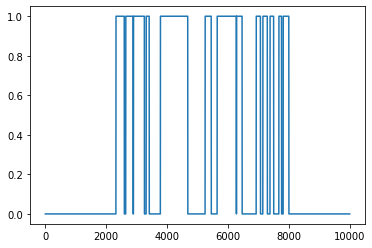

In [74]:
t_max   = 20      # 20 mS
delta_t = 0.01
channel = StochasticKChannel(initial_state=1, voltage=-100)
output_i = channel.go_stochastic(t_max=20, delta_t=delta_t)

channel = StochasticKChannel(initial_state=1, voltage=10)
output_ii = channel.go_stochastic(t_max=60, delta_t=delta_t)

channel = StochasticKChannel(initial_state=1, voltage=-100)
output_iii = channel.go_stochastic(t_max=20, delta_t=delta_t)

outputs = output_i + output_ii + output_iii


plt.plot(outputs)

In [9]:
"""
Channel models can be instantiated directly
from state diagrams simply by keeping track of the state of the channel
and allowing stochastic changes of state to occur at appropriate transition
rates. If the model is updated in short time steps of duration delta_t, the probability that the channel makes a given transition during an update interval
is the transition rate times delta_t.
"""
x = 1
"""
TODOS/Questions:
- What are the values for conductance and Reversal potential? K values?
- 0) Simulate a two state system
- 1) Start by fixing the voltage
- 2) Introduce time! But how? small delta_t
  - safe way to do it is by choosing delta_t 
    according to the largest alpha/beta we can have 
    (largest voltage)
- Compare the temporal mean of stochastic ion channel
  at a fixed voltage with stationary value of n** at same V4 (from HH)
- Meet every Monday (at 3PM)
"""


'\nTODOS/Questions:\n- What are the values for conductance and Reversal potential? K values?\n- 0) Simulate a two state system\n- 1) Start by fixing the voltage\n- 2) Introduce time! But how? small delta_t\n  - safe way to do it is by choosing delta_t \n    according to the largest alpha/beta we can have \n    (largest voltage)\n- Compare the temporal mean of stochastic ion channel\n  at a fixed voltage with stationary value of n** at same V4 (from HH)\n- Meet every Monday (at 3PM)\n'